In [2]:
from geojson import Point

In [306]:
import geojson
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd

In [385]:
from typing import List, Tuple, Union


def shape(ndarray: Union[List, float]) -> Tuple[int, ...]:
    if isinstance(ndarray, list):
        # More dimensions, so make a recursive call
        outermost_size = len(ndarray)
        row_shape = shape(ndarray[0])
        return (outermost_size, *row_shape)
    else:
        # No more dimensions, so we're done
        return ()

In [64]:
data_folder = '/Users/jiaruixu/Downloads/mapping_data/districts_geojson/'

In [273]:
with open(join(data_folder, 'cb_2018_us_cd116_500k.geojson')) as f:
    congress_blob = geojson.load(f)

In [263]:
from os import listdir
from os.path import isfile, join

states_path = join(data_folder, 'states')
onlyfiles = [f for f in listdir(states_path) if isfile(join(states_path, f))]

In [264]:
onlyfiles = [f for f in onlyfiles if 'geojson' in f]

In [265]:
states_database = {}

for filename in onlyfiles:
    with open(join(states_path, filename)) as f:
        states_database[filename] = geojson.load(f)

In [274]:
committee = pd.read_csv(join(data_folder, 'committee.tsv'), delimiter='\t')

In [275]:
committee.dropna(subset=['Chamber'], inplace=True)

In [276]:
committee['state_name'] = committee.State.map(lambda x: us.states.lookup(x).name)

In [277]:
def fill_zero(x):
    if len(x) == 1:
        return "0" + x
    else:
        return x

def get_geoid(member):
    state = member['state_name']
    district_id = str(member['District'])
    congress_geoid = fill_zero(str(state2code[state])) + fill_zero(district_id)
    return congress_geoid

committee['geoid'] = committee.apply(lambda x: get_geoid(x), axis=1)

In [300]:
committee.head()

,Chamber,Legislator,State,District,State-Dist,Party,Committee,Position On Cash Relief,No. of Overlapping State House Members,No. of Overlapping State Senator,No. of Overlapping State Legislators,No. of State Legislators In-District Contacted,No. of State Legislators Signed-On,Key Signees,Letter (linked),state_name,geoid
0,House,"Richard Neal, Chair",MA,1,MA-1,(D),Ways & Means,NaN,0.0,4.0,4.0,NaN,NaN,NaN,NaN,Massachusetts,2501
1,House,Lloyd Doggett,TX,35,TX-35,(D),Ways & Means,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Texas,4835
2,House,Mike Thompson,CA,5,CA-5,(D),Ways & Means,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,California,0605
3,House,John Larson,CT,1,CT-1,(D),Ways & Means,NaN,0.0,11.0,11.0,NaN,NaN,NaN,NaN,Connecticut,0901
4,House,Earl Blumenauer,OR,3,OR-3,(D),Ways & Means,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Oregon,4103


In [279]:
def find_rep(geoid, congress_blob):
    congress = congress_blob['features']
    for rep in congress:
        congress_geoid = rep['properties']['GEOID']
        if congress_geoid == geoid:
            return rep
    return None

In [446]:
def get_polygon(x):
    # shape = np.shape(member_info['geometry']['coordinates'])
    coordinates = x['geometry']['coordinates']
    collect = []
    def make_polygons(coordinates):
        try:
            collect.append(Polygon(coordinates))
        except:
            for x in coordinates:
                make_polygons(x)
    make_polygons(coordinates)
    return MultiPolygon(collect)

In [456]:
results = []

for row_dict in committee.to_dict(orient="records"):
    output_state_id = row_dict['State-Dist']
    output_name = row_dict['Legislator']
    
    geoid = row_dict['geoid']
    member_info = find_rep(geoid, congress_blob)
    p0 = get_polygon(member_info)
    state_name = row_dict['state_name']
    flag = False
    for record_name, records in states_database.items():
        if state == 'Nebraska':
            flag = True
        if "_".join(state_name.split()) not in record_name:
            continue
        legislature_type = 'House'
        if 'Senate' not in record_name:
            continue
            # legislature_type = 'Senate'
        
        legislature = records['features']
        for rep in legislature:
            p1 = get_polygon(rep)
            SLDLST = rep['properties']['SLDUST']
            try:
                if p0.intersects(p1): 
                    if p0.intersection(p1).area> 0.0001:
                        flag=True
                        output_rep = SLDLST.lstrip('0')
                        results.append([output_name, output_state_id, output_rep])
            except:
                print(SLDLST)
    if flag == False:
        print(output_name, output_state_id)

TopologyException: side location conflict at -89.784210999999999 43.635190000000001


014


TopologyException: side location conflict at -88.223349999999996 43.159122000000004


008


TopologyException: side location conflict at -84.298665 32.999670999999999


016


In [455]:
rep['properties']

{'Name': '25001',
 'description': '\n Attributes\n  STATEFP  25 \n  SLDUST  001 \n  AFFGEOID  610U500US25001 \n  GEOID  25001 \n  NAME  First Suffolk \n  LSAD  07 \n  LSY  2016 \n  ALAND  33417879 \n  AWATER  119114290 ',
 'name2': None,
 'STATEFP': '25',
 'SLDUST': '001',
 'AFFGEOID': '610U500US25001',
 'GEOID': '25001',
 'LSAD': '07',
 'LSY': '2016',
 'ALAND': '33417879',
 'AWATER': '119114290'}

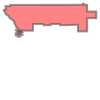

In [449]:
get_polygon(rep)

In [439]:
coordinates = member_info['geometry']['coordinates']
collect = []
def make_polygons(coordinates, collect):
    try:
        # print(coordinates)
        p = Polygon(coordinates)
        print(p)
        collect.append(p)
    except:
        for x in coordinates:
            make_polygons(x, collect)

In [444]:
mp = MultiPolygon(collect)

In [445]:
mp.intersects(mp)

True

In [404]:
rep['geometry']['coordinates'][0]

[[[-70.835635, 42.4844],
  [-70.835635, 42.481915],
  [-70.833228, 42.481442],
  [-70.832426, 42.484164],
  [-70.83371, 42.486412],
  [-70.835635, 42.4844]],
 [[-70.834721, 42.481932],
  [-70.833361, 42.481922],
  [-70.833495, 42.482464],
  [-70.834852, 42.483246],
  [-70.834459, 42.484156],
  [-70.833133, 42.484045],
  [-70.833695, 42.48567],
  [-70.835312, 42.483893],
  [-70.834721, 42.481932]]]

In [405]:
rep['geometry']['coordinates'][1]

[[[-70.942356, 42.46138],
  [-70.941366, 42.460055],
  [-70.939145, 42.45949],
  [-70.939387, 42.458242],
  [-70.936611, 42.456883],
  [-70.935169, 42.456546],
  [-70.935003, 42.457821],
  [-70.934993, 42.457896],
  [-70.927713, 42.460892],
  [-70.926792, 42.461827],
  [-70.92554, 42.463097],
  [-70.921993, 42.466696],
  [-70.92192, 42.466698],
  [-70.916979, 42.466831],
  [-70.908092, 42.466896],
  [-70.907393, 42.463439],
  [-70.907275, 42.462855],
  [-70.901453, 42.464226],
  [-70.894292, 42.460896],
  [-70.887292, 42.464896],
  [-70.887992, 42.467096],
  [-70.886493, 42.470197],
  [-70.886273, 42.470475],
  [-70.879699, 42.478787],
  [-70.879692, 42.478796],
  [-70.870039, 42.483865],
  [-70.860919, 42.488653],
  [-70.857791, 42.490296],
  [-70.847391, 42.491496],
  [-70.841591, 42.487596],
  [-70.835991, 42.490496],
  [-70.833788, 42.499379],
  [-70.831091, 42.503596],
  [-70.83381, 42.505868],
  [-70.840732, 42.499324],
  [-70.844645, 42.496608],
  [-70.844772, 42.49652],
  [-70.

In [374]:
coordinates = rep['geometry']['coordinates']
paths = [c for c in coordinates]
if len(paths) <3:
    paths = [c[0] for c in coordinates]

In [377]:
len([c for c in coordinates])

11

In [362]:
[c for c in coordinates]

[[[[-70.233946, 41.285201],
   [-70.234662, 41.285061],
   [-70.233107, 41.283053],
   [-70.22134, 41.277039],
   [-70.212652, 41.273697],
   [-70.212455, 41.273621],
   [-70.195635, 41.267152],
   [-70.170356, 41.257428],
   [-70.162964, 41.255272],
   [-70.142359, 41.249261],
   [-70.118669, 41.242351],
   [-70.116955, 41.242181],
   [-70.116928, 41.242179],
   [-70.114857, 41.241974],
   [-70.100495, 41.240553],
   [-70.097861, 41.241149],
   [-70.092404, 41.24332],
   [-70.083489, 41.244775],
   [-70.075094, 41.244568],
   [-70.05318, 41.244026],
   [-70.043772, 41.242523],
   [-70.036973, 41.241437],
   [-70.036802, 41.241901],
   [-70.032404, 41.241342],
   [-70.023883, 41.239891],
   [-70.018061, 41.239186],
   [-70.01236, 41.239045],
   [-70.007229, 41.239386],
   [-69.992256, 41.24243],
   [-69.98517, 41.244214],
   [-69.98501, 41.244038],
   [-69.974983, 41.246528],
   [-69.972731, 41.247981],
   [-69.968088, 41.250978],
   [-69.966565, 41.252673],
   [-69.964129, 41.255382],

In [355]:
polygons = [Polygon(c) for c in coordinates]

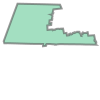

In [357]:
polygons[0]

In [310]:
np.shape(rep['geometry']['coordinates'][0][0])

(263, 2)

In [311]:
np.shape(rep['geometry']['coordinates'])

/Users/jiaruixu/work_space/hf_zip/env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(11, 1)

In [325]:
len(rep['geometry']['coordinates'][0])

1

In [328]:
get_polygonrep['geometry']['coordinates'][3]

[[[-70.686981, 41.52949],
  [-70.687785, 41.524182],
  [-70.685408, 41.521335],
  [-70.678515, 41.521512],
  [-70.673049, 41.523648],
  [-70.670196, 41.520801],
  [-70.668295, 41.517953],
  [-70.664623, 41.517953],
  [-70.662828, 41.517953],
  [-70.656801, 41.514869],
  [-70.656625, 41.514779],
  [-70.654011, 41.515905],
  [-70.654104, 41.519025],
  [-70.650059, 41.524172],
  [-70.643627, 41.532357],
  [-70.64121, 41.53378],
  [-70.6338, 41.538141],
  [-70.633713, 41.538192],
  [-70.633607, 41.538254],
  [-70.622996, 41.540484],
  [-70.621738, 41.540749],
  [-70.617911, 41.541553],
  [-70.616036, 41.541948],
  [-70.614398, 41.542292],
  [-70.611081, 41.542989],
  [-70.607831, 41.54267],
  [-70.601839, 41.542082],
  [-70.600734, 41.542497],
  [-70.59381, 41.545098],
  [-70.58881, 41.545322],
  [-70.589095, 41.550662],
  [-70.591319, 41.554272],
  [-70.592394, 41.560058],
  [-70.592686, 41.560816],
  [-70.593288, 41.563949],
  [-70.596102, 41.564459],
  [-70.595995, 41.56479],
  [-70.594

In [322]:
MultiPolygon(rep['geometry']['coordinates'])

IndexError: list index out of range

In [305]:
np.shape(member_info['geometry']['coordinates'])

(2, 1)

In [457]:
pd.DataFrame.from_records(results).to_csv('senate_2.csv')

In [301]:
member_info['geometry']['coordinates']

[[[[-95.948483, 31.298886],
   [-95.947616, 31.297937],
   [-95.946943, 31.297908],
   [-95.946675, 31.298329],
   [-95.947168, 31.298558],
   [-95.948483, 31.298886]]],
 [[[-96.272347, 31.092559],
   [-96.272058, 31.089546],
   [-96.270193, 31.087515],
   [-96.269335, 31.087672],
   [-96.263353, 31.085268],
   [-96.261253, 31.082783],
   [-96.261594, 31.078694],
   [-96.260594, 31.077071],
   [-96.25824, 31.076142],
   [-96.256301, 31.074065],
   [-96.254272, 31.073878],
   [-96.252425, 31.072335],
   [-96.25426, 31.072419],
   [-96.257098, 31.069294],
   [-96.255771, 31.06787],
   [-96.255466, 31.065521],
   [-96.253273, 31.066384],
   [-96.253258, 31.064324],
   [-96.251261, 31.064822],
   [-96.250757, 31.063222],
   [-96.249487, 31.063494],
   [-96.24839, 31.060818],
   [-96.246126, 31.061369],
   [-96.247056, 31.062338],
   [-96.243518, 31.061788],
   [-96.243258, 31.061137],
   [-96.24429, 31.059969],
   [-96.241844, 31.056778],
   [-96.244283, 31.056596],
   [-96.24318, 31.05509

In [270]:
"312".lstrip('0')

'312'

In [271]:
"_".join(state_name.split())

'Kansas'

In [285]:
nj = states_database['Illinois_State_House.geojson']

In [286]:
for rep in nj['features']:
    p1 = get_polygon(rep)
    state_rep_geoid = rep['properties']['SLDLST']
    print(state_rep_geoid)

001
002
003
004
005
013
006
007
014
008
009
010
011
012
015
016
017
018
019
020
021
022
023
024
025
026
030
027
028
029
039
031
040
032
033
034
035
036
037
038
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
066
063
064
083
065
084
067
068
069
070
071
072
085
073
074
075
076
086
087
077
078
079
092
093
080
103
081
082
088
089
090
091
094
095
096
105
097
098
099
100
101
102
104
106
107
108
109
110
111
112
113
114
115
116
117
118


In [240]:
rep['properties']

{'Name': '20123',
 'description': '\n Attributes\n  STATEFP  20 \n  SLDLST  123 \n  AFFGEOID  620L500US20123 \n  GEOID  20123 \n  NAME  123 \n  LSAD  LL \n  LSY  2016 \n  ALAND  18640973 \n  AWATER  0 ',
 'name2': None,
 'STATEFP': '20',
 'SLDLST': '123',
 'AFFGEOID': '620L500US20123',
 'GEOID': '20123',
 'LSAD': 'LL',
 'LSY': '2016',
 'ALAND': '18640973',
 'AWATER': '0'}

In [ ]:
congress = congress_blob['features']

for rep in congress:
    congress_geoid = rep['properties']['GEOID']
    try:
        rep_area = Polygon(rep['geometry']['coordinates'][0])
    except:
        rep_area = Polygon(rep['geometry']['coordinates'][0][0])
    print(congress_geoid)

In [120]:
import us


In [121]:
state = us.states.lookup('ma')

In [123]:
state.name

'Massachusetts'

In [99]:
from geoid import censusnames   

In [97]:
state2code = {}

for code_pair, place in censusnames.geo_names.items():
    state = place.split(', ')[-1]   
    state2code[state] = code_pair[0]

In [98]:
state2code

{'US': 0,
 'Alabama': 1,
 'Alaska': 2,
 'Arizona': 4,
 'Arkansas': 5,
 'California': 6,
 'Colorado': 8,
 'Connecticut': 9,
 'Delaware': 10,
 'District of Columbia': 11,
 'Florida': 12,
 'Georgia': 13,
 'Hawaii': 15,
 'Idaho': 16,
 'Illinois': 17,
 'Indiana': 18,
 'Iowa': 19,
 'Kansas': 20,
 'Kentucky': 21,
 'Louisiana': 22,
 'Maine': 23,
 'Maryland': 24,
 'Massachusetts': 25,
 'Michigan': 26,
 'Minnesota': 27,
 'Mississippi': 28,
 'Missouri': 29,
 'Montana': 30,
 'Nebraska': 31,
 'Nevada': 32,
 'New Hampshire': 33,
 'New Jersey': 34,
 'New Mexico': 35,
 'New York': 36,
 'North Carolina': 37,
 'North Dakota': 38,
 'Ohio': 39,
 'Oklahoma': 40,
 'Oregon': 41,
 'Pennsylvania': 42,
 'Rhode Island': 44,
 'South Carolina': 45,
 'South Dakota': 46,
 'Tennessee': 47,
 'Texas': 48,
 'Utah': 49,
 'Vermont': 50,
 'Virginia': 51,
 'Washington': 53,
 'West Virginia': 54,
 'Wisconsin': 55,
 'Wyoming': 56,
 'Puerto Rico': 72}

In [12]:
from shapely.geometry import Polygon
p1 = Polygon([(0,0), (1,1), (1,0)])
p2 = Polygon([(0,1), (1,0), (1,1)])
print(p1.intersects(p2))

True


In [13]:
with open('/Users/jiaruixu/Downloads/mapping_data/districts_geojson/Alabama_State_Senate.geojson') as f:
    senate = geojson.load(f)
    
with open('/Users/jiaruixu/Downloads/mapping_data/districts_geojson/Alabama_State_House_Districts.geojson') as f:
    house = geojson.load(f)

In [ ]:
def path_to_geos(path, force_ccw=False):
         elif (path_verts.shape[0] > 2 and
                 (path_codes[-1] == Path.CLOSEPOLY or
                  verts_same_as_first[-1])):
-            if path_codes[-1] == Path.CLOSEPOLY:
-                geom = sgeom.Polygon(path_verts[:-1, :])
-            else:
-                geom = sgeom.Polygon(path_verts)
+            geom = sgeom.Polygon(path_verts)
         else:
             geom = sgeom.LineString(path_verts)

In [43]:
h0 = house['features'][0]
ph = Polygon(h0['geometry']['coordinates'][0])
for s in senate['features']:
    try:
        ps = Polygon(s['geometry']['coordinates'][0])
        if ph.intersects(ps): 
            print(s['properties']['GEOID'])
    except:
        failed = s
        print("FAIL", s['properties']['GEOID'])

01001
01006
FAIL 01008
FAIL 01035


In [39]:
failed['geometry']['coordinates'][0]

[[[-88.053375, 30.506987],
  [-88.052349, 30.505591],
  [-88.045043, 30.501189],
  [-88.026748, 30.491105],
  [-88.02433, 30.490774],
  [-88.023506, 30.492573],
  [-88.026222, 30.516609],
  [-88.029165, 30.519648],
  [-88.032407, 30.521447],
  [-88.035099, 30.521967],
  [-88.03867, 30.520405],
  [-88.041966, 30.517376],
  [-88.045647, 30.513306],
  [-88.051088, 30.508857],
  [-88.053375, 30.506987]]]

In [22]:
h0['properties']['GEOID']

'01001'

In [41]:
ps = Polygon([[-88.053375, 30.506987],
  [-88.052349, 30.505591],
  [-88.045043, 30.501189],
  [-88.026748, 30.491105],
  [-88.02433, 30.490774],
  [-88.023506, 30.492573],
  [-88.026222, 30.516609],
  [-88.029165, 30.519648],
  [-88.032407, 30.521447],
  [-88.035099, 30.521967],
  [-88.03867, 30.520405],
  [-88.041966, 30.517376],
  [-88.045647, 30.513306],
  [-88.051088, 30.508857],
  [-88.053375, 30.506987]])